# Music Recomendations

In [ ]:
!pip install catboost==1.0.3
!pip install gensim==4.1.0
!pip install --upgrade numpy
!pip install shap

In [ ]:
!nvidia-smi

Sun Nov 28 10:20:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%cd /content
!wget https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz
!tar -xf /content/wsdm_data.tar.gz
!mkdir data
!mv -t data members.csv song_extra_info.csv songs.csv train.csv
!git clone -b hw2 https://github.com/Sushentsev/recommendation-systems
%cd recommendation-systems/
!mv /content/data /content/recommendation-systems/hw2

/content
--2021-11-28 09:52:17--  https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz
Resolving voudy-data.s3.eu-north-1.amazonaws.com (voudy-data.s3.eu-north-1.amazonaws.com)... 52.95.171.20
Connecting to voudy-data.s3.eu-north-1.amazonaws.com (voudy-data.s3.eu-north-1.amazonaws.com)|52.95.171.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 613394184 (585M) [application/x-gzip]
Saving to: ‘wsdm_data.tar.gz’

wsdm_data.tar.gz    100%[===================>] 584.98M  10.9MB/s    in 56s     

2021-11-28 09:53:14 (10.4 MB/s) - ‘wsdm_data.tar.gz’ saved [613394184/613394184]

Cloning into 'recommendation-systems'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 127 (delta 71), reused 85 (delta 33), pack-reused 0
Receiving objects: 100% (127/127), 6.48 MiB | 13.19 MiB/s, done.
Resolving deltas: 100% (71/71), done.
/content/recommendation-systems


In [11]:
%cd /content/recommendation-systems/hw2

/content/recommendation-systems/hw2


In [12]:
import sys
sys.path.append("/content/recommendation-systems")

In [1]:
from datasets.members import MembersDataset
from datasets.songs import SongsDataset
from datasets.train import TrainDataset
from datasets.songs_info import SongsInfoDataset

from models.catboost_model import CatBoostModel
from models.embeddings_model import EmbeddingModel
from models.combined_model import CombinedModel

from embeddings_builder import EmbeddingsBuilder

from plot import * 
from utils import * 
from sklearn.model_selection import train_test_split
from catboost import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

%load_ext autoreload
%autoreload 2

## Подготовка данных

In [2]:
random_state = 42

Загрузим данные в память. 

In [3]:
%%time
members_dataset = MembersDataset.from_path("./data/members.csv")
songs_dataset = SongsDataset.from_path("./data/songs.csv")
train_dataset = TrainDataset.from_path("./data/train.csv")
songs_info_dataset = SongsInfoDataset.from_path("./data/song_extra_info.csv")

CPU times: user 1min 3s, sys: 1.72 s, total: 1min 5s
Wall time: 1min 5s


Построим признаки для песен и пользователей и посмотрим, что получилось. 

In [4]:
%%time
members_dataset = members_dataset.create_features()
songs_dataset = songs_dataset.create_features(songs_info_dataset)

CPU times: user 12.5 s, sys: 682 ms, total: 13.1 s
Wall time: 13.2 s


In [5]:
members_dataset.pandas_df.head(3)

,msno,city,gender,registered_via,bd_category,registration_init_year,expiration_date_year
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,<UNK>,7,<UNK>,2011,2017
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,<UNK>,7,<UNK>,2015,2017
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,<UNK>,4,<UNK>,2016,2017


In [6]:
songs_dataset.pandas_df.head(3)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,genres_count,artist_name_count,composer_count,lyricists_count,isrc_year
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,1,1,1,1,2014
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,1,1,3,1,-1
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,<UNK>,<UNK>,31.0,1,1,0,0,-1


Теперь добавим в обучающую выборку признаков из песен и пользователей. 

In [7]:
train_dataset = train_dataset.merge(members_dataset, on="msno", how="left")
train_dataset = train_dataset.merge(songs_dataset, on="song_id", how="left")

In [8]:
train_dataset.pandas_df.head(3)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,gender,registered_via,bd_category,...,genre_ids,artist_name,composer,lyricist,language,genres_count,artist_name_count,composer_count,lyricists_count,isrc_year
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,<UNK>,7,<UNK>,...,359,Bastille,Dan Smith| Mark Crew,<UNK>,52.0,1.0,1.0,2.0,0.0,2016
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,female,9,young,...,1259,Various Artists,<UNK>,<UNK>,52.0,1.0,1.0,0.0,0.0,1999
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,female,9,young,...,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,<UNK>,52.0,1.0,1.0,1.0,0.0,2006


Теперь преобразуем некоторые колонки категориальным значениям и заполнил пропуски. 

In [9]:
train_dataset.to_category(["msno", "song_id"])
train_dataset.fill_na_category(["source_system_tab", "source_screen_name", "source_type"])

In [10]:
train_dataset.pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 23 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   msno                    category
 1   song_id                 category
 2   source_system_tab       category
 3   source_screen_name      category
 4   source_type             category
 5   target                  int64   
 6   city                    category
 7   gender                  category
 8   registered_via          category
 9   bd_category             category
 10  registration_init_year  int64   
 11  expiration_date_year    int64   
 12  song_length             float64 
 13  genre_ids               category
 14  artist_name             category
 15  composer                category
 16  lyricist                category
 17  language                category
 18  genres_count            float64 
 19  artist_name_count       float64 
 20  composer_count          float64 
 21  lyricist

Все круто!

In [11]:
na_mask = train_dataset.pandas_df.isna().any(axis=1)
print(f"Количество записей, для которых не нашлось пользователя или песни: {sum(na_mask)}")

Количество записей, для которых не нашлось пользователя или песни: 114


Их оказалось не так много, уберем из нашего набора данных.

In [12]:
train_dataset = train_dataset.remove_by_mask(na_mask)

Так как **CatBoost** на CPU обучается достаточно долго (больше часа), то было решено обучать на GPU. Однако GPU не поддерживает группы больше 1023, поэтому тренировочный набор данных был уменьшен. При этом, желательно сохранить порядок записей.

In [13]:
train_dataset_sm = train_dataset.reduce_by_members(size=1023)

In [14]:
train_dataset_sm.pandas_df.target.value_counts()

1    3564182
0    3451109
Name: target, dtype: int64

Соотношение классов осталось тем же, все хорошо. Изменение размеров: 7377304 -> 7015291

In [15]:
print(f"{len(train_dataset)} -> {len(train_dataset_sm)}")

7377304 -> 7015291


## Задание 1

Построить рекомендации для каждого пользователя, произвести оценку качества с помощью 5-fold CV с метриками NDCG, ROC AUC per user.

При разработке признаков я умеренно не стал брать признаки, полученные с помощью матричных факторизаций, чтобы потом добавить неклассические эмбеддинги, полученные в задании 2. 

Для **CatBoost** необоходимо, чтобы данные были упорядочены по **queries**. 

In [ ]:
train_dataset_sm_sort = train_dataset_sm.sort_by("msno")
model = CatBoostModel("YetiRank", 150, "GPU", random_state)
scores = model.cv_scores(train_dataset_sm_sort, n_splits=5)

Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.32s	remaining: 3m 17s
1:	total: 2.49s	remaining: 3m 4s
2:	total: 3.66s	remaining: 2m 59s
3:	total: 4.84s	remaining: 2m 56s
4:	total: 6.01s	remaining: 2m 54s
5:	total: 7.18s	remaining: 2m 52s
6:	total: 8.35s	remaining: 2m 50s
7:	total: 9.53s	remaining: 2m 49s
8:	total: 10.7s	remaining: 2m 47s
9:	total: 11.9s	remaining: 2m 46s
10:	total: 13.1s	remaining: 2m 45s
11:	total: 14.3s	remaining: 2m 43s
12:	total: 15.4s	remaining: 2m 42s
13:	total: 16.6s	remaining: 2m 41s
14:	total: 17.8s	remaining: 2m 40s
15:	total: 19s	remaining: 2m 38s
16:	total: 20.2s	remaining: 2m 37s
17:	total: 21.3s	remaining: 2m 36s
18:	total: 22.5s	remaining: 2m 35s
19:	total: 23.7s	remaining: 2m 33s
20:	total: 24.9s	remaining: 2m 32s
21:	total: 26.1s	remaining: 2m 31s
22:	total: 27.2s	remaining: 2m 30s
23:	total: 28.4s	remaining: 2m 29s
24:	total: 29.6s	remaining: 2m 27s
25:	total: 30.7s	remaining: 2m 26s
26:	total: 31.9s	remaining: 2m 25s
27:	total: 33.1s	remaining: 2m 24s
28:	total: 34.3s	remaining: 2m 22

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.32s	remaining: 3m 16s
1:	total: 2.49s	remaining: 3m 4s
2:	total: 3.66s	remaining: 2m 59s
3:	total: 4.84s	remaining: 2m 56s
4:	total: 6.02s	remaining: 2m 54s
5:	total: 7.19s	remaining: 2m 52s
6:	total: 8.36s	remaining: 2m 50s
7:	total: 9.54s	remaining: 2m 49s
8:	total: 10.7s	remaining: 2m 47s
9:	total: 11.9s	remaining: 2m 46s
10:	total: 13.1s	remaining: 2m 45s
11:	total: 14.3s	remaining: 2m 43s
12:	total: 15.4s	remaining: 2m 42s
13:	total: 16.6s	remaining: 2m 41s
14:	total: 17.8s	remaining: 2m 40s
15:	total: 19s	remaining: 2m 38s
16:	total: 20.1s	remaining: 2m 37s
17:	total: 21.3s	remaining: 2m 36s
18:	total: 22.5s	remaining: 2m 35s
19:	total: 23.7s	remaining: 2m 33s
20:	total: 24.9s	remaining: 2m 32s
21:	total: 26s	remaining: 2m 31s
22:	total: 27.2s	remaining: 2m 30s
23:	total: 28.4s	remaining: 2m 29s
24:	total: 29.6s	remaining: 2m 27s
25:	total: 30.7s	remaining: 2m 26s
26:	total: 31.9s	remaining: 2m 25s
27:	total: 33.1s	remaining: 2m 24s
28:	total: 34.3s	remaining: 2m 23s


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.32s	remaining: 3m 16s
1:	total: 2.5s	remaining: 3m 4s
2:	total: 3.67s	remaining: 2m 59s
3:	total: 4.85s	remaining: 2m 57s
4:	total: 6.02s	remaining: 2m 54s
5:	total: 7.19s	remaining: 2m 52s
6:	total: 8.36s	remaining: 2m 50s
7:	total: 9.53s	remaining: 2m 49s
8:	total: 10.7s	remaining: 2m 47s
9:	total: 11.9s	remaining: 2m 46s
10:	total: 13.1s	remaining: 2m 45s
11:	total: 14.2s	remaining: 2m 43s
12:	total: 15.4s	remaining: 2m 42s
13:	total: 16.6s	remaining: 2m 41s
14:	total: 17.8s	remaining: 2m 39s
15:	total: 18.9s	remaining: 2m 38s
16:	total: 20.1s	remaining: 2m 37s
17:	total: 21.3s	remaining: 2m 36s
18:	total: 22.5s	remaining: 2m 34s
19:	total: 23.6s	remaining: 2m 33s
20:	total: 24.8s	remaining: 2m 32s
21:	total: 26s	remaining: 2m 31s
22:	total: 27.2s	remaining: 2m 30s
23:	total: 28.3s	remaining: 2m 28s
24:	total: 29.5s	remaining: 2m 27s
25:	total: 30.7s	remaining: 2m 26s
26:	total: 31.9s	remaining: 2m 25s
27:	total: 33s	remaining: 2m 23s
28:	total: 34.2s	remaining: 2m 22s
2

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.34s	remaining: 3m 19s
1:	total: 2.51s	remaining: 3m 5s
2:	total: 3.67s	remaining: 3m
3:	total: 4.84s	remaining: 2m 56s
4:	total: 6.01s	remaining: 2m 54s
5:	total: 7.19s	remaining: 2m 52s
6:	total: 8.35s	remaining: 2m 50s
7:	total: 9.52s	remaining: 2m 48s
8:	total: 10.7s	remaining: 2m 47s
9:	total: 11.9s	remaining: 2m 45s
10:	total: 13s	remaining: 2m 44s
11:	total: 14.2s	remaining: 2m 43s
12:	total: 15.4s	remaining: 2m 41s
13:	total: 16.5s	remaining: 2m 40s
14:	total: 17.7s	remaining: 2m 39s
15:	total: 18.9s	remaining: 2m 38s
16:	total: 20s	remaining: 2m 36s
17:	total: 21.2s	remaining: 2m 35s
18:	total: 22.4s	remaining: 2m 34s
19:	total: 23.5s	remaining: 2m 33s
20:	total: 24.7s	remaining: 2m 31s
21:	total: 25.9s	remaining: 2m 30s
22:	total: 27.1s	remaining: 2m 29s
23:	total: 28.2s	remaining: 2m 28s
24:	total: 29.4s	remaining: 2m 27s
25:	total: 30.6s	remaining: 2m 25s
26:	total: 31.7s	remaining: 2m 24s
27:	total: 32.9s	remaining: 2m 23s
28:	total: 34.1s	remaining: 2m 22s
29:	

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.33s	remaining: 3m 17s
1:	total: 2.5s	remaining: 3m 5s
2:	total: 3.67s	remaining: 2m 59s
3:	total: 4.84s	remaining: 2m 56s
4:	total: 6.01s	remaining: 2m 54s
5:	total: 7.18s	remaining: 2m 52s
6:	total: 8.35s	remaining: 2m 50s
7:	total: 9.52s	remaining: 2m 49s
8:	total: 10.7s	remaining: 2m 47s
9:	total: 11.9s	remaining: 2m 46s
10:	total: 13.1s	remaining: 2m 44s
11:	total: 14.2s	remaining: 2m 43s
12:	total: 15.4s	remaining: 2m 42s
13:	total: 16.6s	remaining: 2m 41s
14:	total: 17.8s	remaining: 2m 39s
15:	total: 18.9s	remaining: 2m 38s
16:	total: 20.1s	remaining: 2m 37s
17:	total: 21.3s	remaining: 2m 36s
18:	total: 22.5s	remaining: 2m 34s
19:	total: 23.7s	remaining: 2m 33s
20:	total: 24.8s	remaining: 2m 32s
21:	total: 26s	remaining: 2m 31s
22:	total: 27.2s	remaining: 2m 30s
23:	total: 28.4s	remaining: 2m 28s
24:	total: 29.6s	remaining: 2m 27s
25:	total: 30.7s	remaining: 2m 26s
26:	total: 31.9s	remaining: 2m 25s
27:	total: 33.1s	remaining: 2m 24s
28:	total: 34.3s	remaining: 2m 22s

In [ ]:
print(f"Average NDCG: {np.mean(scores['NDCG']):.4f}")
print(f"Average ROC AUC per user: {np.mean(scores['ROC_AUC']):.4f}")

Average NDCG: 0.8397
Average ROC AUC per user: 0.6457


## Задание 2

Построить неклассические эмбеддинги и исследовать их полезность.

In [ ]:
%%time
embeddings = EmbeddingsBuilder(embedding_dim=100, random_state=random_state)
embeddings = embeddings.fit(train_dataset_sm_sort)
save_pickle(embeddings, "embeddings.pkl")

Fitting items
Fitting users


100%|██████████| 30755/30755 [18:36<00:00, 27.54it/s]


CPU times: user 22min 22s, sys: 18.3 s, total: 22min 41s
Wall time: 20min 55s


In [ ]:
embeddings = load_pickle("embeddings.pkl")

Посмотрим на похожие песни и пользователей, визуализировав их с помощью PCA. Будем называть песни похожими, если они принадлежат к одному жанру.

In [ ]:
songs, genres = songs_dataset.similar_songs(n_groups=5)

In [ ]:
np.unique(genres, return_counts=True)

(array(['1609', '2022', '2122', '465', '958'], dtype=object),
 array([166457, 168870, 139938, 567911, 176349]))

Так как есть очень большой класс, уберем его. 

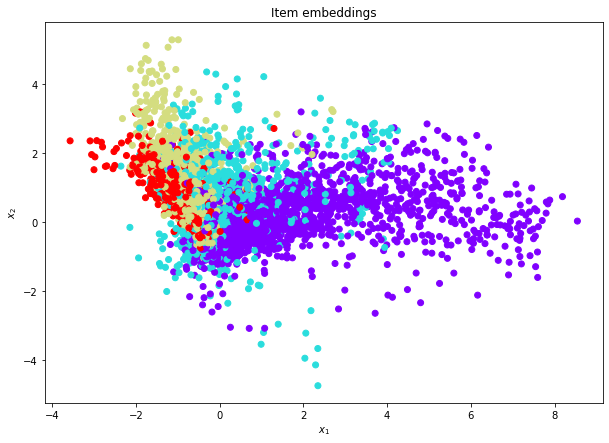

In [ ]:
genres_mask = (genres != "465")
songs_mask = np.array([embeddings.has_item(song) for song in songs])

mask = genres_mask & songs_mask
plot_similar(embeddings.get_item_embeddings(songs[mask]), genres[mask], "Item embeddings")

Как можно видеть, получились некоторые кластеры, обучим модель. 

In [ ]:
%%time
train_dataset_sm_sort = train_dataset_sm.sort_by("msno")
model = EmbeddingModel(100, random_state=random_state)
scores = model.cv_scores(train_dataset_sm_sort, n_splits=5)

Train size: 5612232 | Test size: 1403059
Fitting items
Fitting users


100%|██████████| 30755/30755 [19:34<00:00, 26.19it/s]


NDCG: 0.8463 | ROC AUC: 0.6345
Train size: 5612233 | Test size: 1403058
Fitting items
Fitting users


100%|██████████| 30755/30755 [20:28<00:00, 25.04it/s]


NDCG: 0.8458 | ROC AUC: 0.6340
Train size: 5612233 | Test size: 1403058
Fitting items
Fitting users


100%|██████████| 30755/30755 [21:06<00:00, 24.29it/s]


NDCG: 0.8455 | ROC AUC: 0.6339
Train size: 5612233 | Test size: 1403058
Fitting items
Fitting users


100%|██████████| 30755/30755 [20:21<00:00, 25.18it/s]


NDCG: 0.8463 | ROC AUC: 0.6351
Train size: 5612233 | Test size: 1403058
Fitting items
Fitting users


100%|██████████| 30755/30755 [20:32<00:00, 24.96it/s]


NDCG: 0.8456 | ROC AUC: 0.6328
CPU times: user 2h 8min 4s, sys: 1min 7s, total: 2h 9min 12s
Wall time: 2h 1min 32s


In [ ]:
print(f"Average NDCG: {np.mean(scores['NDCG']):.4f}")
print(f"Average ROC AUC per user: {np.mean(scores['ROC_AUC']):.4f}")

Average NDCG: 0.8459
Average ROC AUC per user: 0.6341


Получили сопоставимое качество с CatBoost, наверное, это норм. Теперь протестируем модели вместе. 

In [ ]:
train_dataset_sm_sort = train_dataset_sm.sort_by("msno")
model = CombinedModel("YetiRank", 150, 100, "GPU", random_state=random_state)
scores = model.cv_scores(train_dataset_sm_sort, n_splits=5)

Train size: 5612232 | Test size: 1403059
Fitting items
Fitting users
100%|██████████| 30755/30755 [17:19<00:00, 29.58it/s]
Fitted embedding model
Fitted catboost
Train size: 5612233 | Test size: 1403058
Fitting items
Fitting users
100%|██████████| 30755/30755 [18:15<00:00, 28.14it/s]
Fitted embedding model
Fitted catboost
Train size: 5612233 | Test size: 1403058
Fitting items
Fitting users
100%|██████████| 30755/30755 [17:06<00:00, 30.01it/s]
Fitted embedding model
Fitted catboost
Train size: 5612233 | Test size: 1403058
Fitting items
Fitting users
100%|██████████| 30755/30755 [17:31<00:00, 29.31it/s]
Fitted embedding model
Fitted catboost
Train size: 5612233 | Test size: 1403058
Fitting items
Fitting users
100%|██████████| 30755/30755 [16:54<00:00, 30.44it/s]
Fitted embedding model
Fitted catboost


In [ ]:
print(f"Average NDCG: {np.mean(scores['NDCG']):.4f}")
print(f"Average ROC AUC per user: {np.mean(scores['ROC_AUC']):.4f}")

Average NDCG: 0.8714
Average ROC AUC per user: 0.6510


Как можно видеть, метрики улучшились. Исследуем shap values.

In [16]:
train_dataset_sm_sort = train_dataset_sm.sort_by("msno")
indices = np.random.permutation(len(train_dataset_sm_sort))
train_indices, test_indices = train_test_split(indices, test_size=1_000)
train_indices = sorted(train_indices)
test_indices = sorted(test_indices)

X_train = TrainDataset(train_dataset_sm_sort.pandas_df.iloc[train_indices])
X_test = TrainDataset(train_dataset_sm_sort.pandas_df.iloc[test_indices])

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")

Train size: 7014291 | Test size: 1000


In [17]:
emb_model = EmbeddingModel(embedding_dim=100, random_state=random_state)
emb_model = emb_model.fit(X_train)
train_scores = emb_model.predict(X_train)
test_scores = emb_model.predict(X_test)

Fitting items
Fitting users


100%|██████████| 30755/30755 [16:01<00:00, 31.99it/s]


In [20]:
X_train_df = X_train.pandas_df.reset_index(drop=True)
X_train_df["sim"] = train_scores 

X_test_df = X_test.pandas_df.reset_index(drop=True)
X_test_df["sim"] = test_scores

In [22]:
model = CatBoostRanker(loss_function="YetiRank", iterations=150)

In [23]:
def to_pool(df): 
    cat_features = df.select_dtypes(include=["category"]).columns.to_numpy()
    
    data = df.drop("target", axis=1)
    label = df.target.to_numpy()
    group_id = df.msno.cat.codes.to_numpy()
    
    pool = Pool(data=data, label=label, group_id=group_id,
                cat_features=cat_features, has_header=True)
    
    return pool

In [24]:
model.fit(to_pool(X_train_df))

Groupwise loss function. OneHotMaxSize set to 10
0:	total: 17.6s	remaining: 43m 45s
1:	total: 34.4s	remaining: 42m 27s
2:	total: 50.1s	remaining: 40m 56s
3:	total: 1m 6s	remaining: 40m 20s
4:	total: 1m 22s	remaining: 39m 41s
5:	total: 1m 37s	remaining: 39m 9s
6:	total: 1m 54s	remaining: 38m 57s
7:	total: 2m 10s	remaining: 38m 29s
8:	total: 2m 25s	remaining: 38m 5s
9:	total: 2m 41s	remaining: 37m 44s
10:	total: 2m 57s	remaining: 37m 25s
11:	total: 3m 13s	remaining: 37m 8s
12:	total: 3m 30s	remaining: 36m 53s
13:	total: 3m 45s	remaining: 36m 34s
14:	total: 4m 1s	remaining: 36m 16s
15:	total: 4m 17s	remaining: 35m 59s
16:	total: 4m 33s	remaining: 35m 40s
17:	total: 4m 49s	remaining: 35m 23s
18:	total: 5m 5s	remaining: 35m 6s
19:	total: 5m 21s	remaining: 34m 49s
20:	total: 5m 37s	remaining: 34m 32s
21:	total: 5m 54s	remaining: 34m 22s
22:	total: 6m 11s	remaining: 34m 9s
23:	total: 6m 28s	remaining: 33m 57s
24:	total: 6m 45s	remaining: 33m 47s
25:	total: 7m 3s	remaining: 33m 40s
26:	total: 

In [25]:
shap_values = model.get_feature_importance(to_pool(X_test_df), type="ShapValues", shap_calc_type="Exact")[:, :-1]

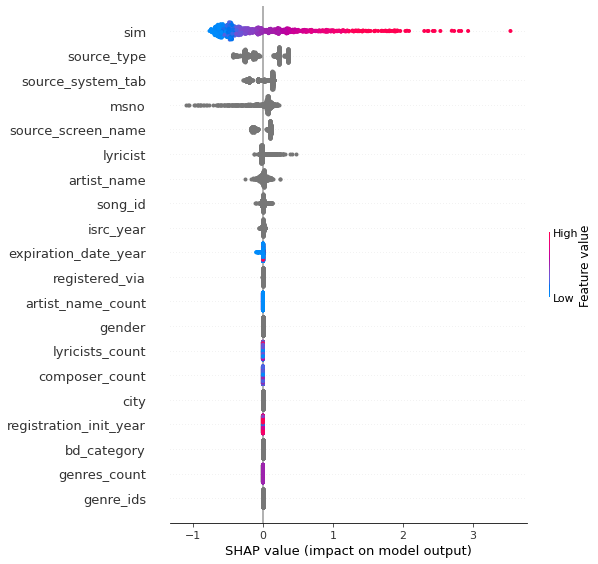

In [27]:
shap.summary_plot(shap_values, X_test_df.drop("target", axis=1))

Similarity -- самый важный признак. 